In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as Math
import tensorflow
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv2D, TimeDistributed, LSTM, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import math, time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import random
import os

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
BASIN = 'WPSep2020ToSep2021' # Change to BASIN you want to work for

path1 = os.getcwd()+'/'

#Limiting GPU RAM. Comment these lines if you are not working on a shared GPU.
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth=True
sess = tensorflow.compat.v1.Session(config=config)

Using TensorFlow backend.


Num GPUs Available:  1


In [2]:
filePath = path1 + 'WPSep2020ToSep2021reanalysisDataClass.csv'
data = pd.read_csv(filePath, index_col=0)

In [3]:
#Scaling the data
total_hurricane_count = len(pd.unique(data['SID']))
print("total hurricane count  ", total_hurricane_count)
gridSize = 41
total = gridSize*gridSize
scalers = {}
cols = []

for i in range(total):
  cols.append('r225_'+str(i))
for i in range(total):
  cols.append('r500_'+str(i))
for i in range(total):
  cols.append('r700_'+str(i))
for i in range(total):
  cols.append('t225_'+str(i))
for i in range(total):
  cols.append('t500_'+str(i))
for i in range(total):
  cols.append('t700_'+str(i))


for i in range(total):
  cols.append('u225_'+str(i))
for i in range(total):
  cols.append('u500_'+str(i))
for i in range(total):
  cols.append('u700_'+str(i))
for i in range(total):
  cols.append('v225_'+str(i))
for i in range(total):
  cols.append('v500_'+str(i))
for i in range(total):
  cols.append('v700_'+str(i))
for i in range(total):
  cols.append('z225_'+str(i))
for i in range(total):
  cols.append('z500_'+str(i))
for i in range(total):
  cols.append('z700_'+str(i))

for col in cols:
    scaler = MinMaxScaler((-1,1))
    scaler.fit(data[[col]])
    data[[col]] = scaler.transform(data[[col]])

cols.append('cateogry')


total hurricane count   50


In [4]:
data_pad = []

for key in np.unique(data['SID']):
    data_pad += [data[ data.loc[:, 'SID'] == key].loc[:, cols].values]

In [5]:
# Extracting features indexes and adjusting them as per used features, to index in data_pad.

offset = 4  #As SID, ISO_TIME, LAt, LON not used.


r225fIndex = data.columns.get_loc('r225_0')-offset
r225lIndex = data.columns.get_loc('r225_1680')-offset 
t225fIndex = data.columns.get_loc('t225_0')-offset
t225lIndex = data.columns.get_loc('t225_1680')-offset 
u225fIndex = data.columns.get_loc('u225_0')-offset
u225lIndex = data.columns.get_loc('u225_1680')-offset 
v225fIndex = data.columns.get_loc('v225_0')-offset
v225lIndex = data.columns.get_loc('v225_1680')-offset 
z225fIndex = data.columns.get_loc('z225_0')-offset
z225lIndex = data.columns.get_loc('z225_1680')-offset


r500fIndex = data.columns.get_loc('r500_0')-offset
r500lIndex = data.columns.get_loc('r500_1680')-offset
t500fIndex = data.columns.get_loc('t500_0')-offset
t500lIndex = data.columns.get_loc('t500_1680')-offset
u500fIndex = data.columns.get_loc('u500_0')-offset
u500lIndex = data.columns.get_loc('u500_1680')-offset
v500fIndex = data.columns.get_loc('v500_0')-offset
v500lIndex = data.columns.get_loc('v500_1680')-offset
z500fIndex = data.columns.get_loc('z500_0')-offset
z500lIndex = data.columns.get_loc('z500_1680')-offset


r700fIndex = data.columns.get_loc('r700_0')-offset
r700lIndex = data.columns.get_loc('r700_1680')-offset
t700fIndex = data.columns.get_loc('t700_0')-offset
t700lIndex = data.columns.get_loc('t700_1680')-offset 
u700fIndex = data.columns.get_loc('u700_0')-offset
u700lIndex = data.columns.get_loc('u700_1680')-offset
v700fIndex = data.columns.get_loc('v700_0')-offset
v700lIndex = data.columns.get_loc('v700_1680')-offset 
z700fIndex = data.columns.get_loc('z700_0')-offset 
z700lIndex = data.columns.get_loc('z700_1680')-offset 

cateogryIndex = data.columns.get_loc('cateogry')-offset

gridSize = 41

#Training dataset prepearation.
def load_dataCNN(data_pad, trainPoints):
    X = []
    y = []
    leads = []
    #count  = 0
    for cdata in data_pad:
      #count = count + 1
      yy = cdata[0][cateogryIndex]
      length = len(cdata)
      diff = length - trainPoints +1
      for i in range(diff):
          data2 = []
          cc1 = cdata[i : i + trainPoints]
          leads.append(diff-i)
          for j in range(trainPoints):
              data1 = []
              value = cc1[j]
                
              r225 = np.reshape(value[r225fIndex: r225lIndex+1], (gridSize,gridSize))
              r500 = np.reshape(value[r500fIndex: r500lIndex+1], (gridSize,gridSize))
              r700 = np.reshape(value[r700fIndex: r700lIndex+1], (gridSize,gridSize))

              t225 = np.reshape(value[t225fIndex: t225lIndex+1], (gridSize,gridSize))
              t500 = np.reshape(value[t500fIndex: t500lIndex+1], (gridSize,gridSize))
              t700 = np.reshape(value[t700fIndex: t700lIndex+1], (gridSize,gridSize))
            
              u225 = np.reshape(value[u225fIndex: u225lIndex+1], (gridSize,gridSize))
              u500 = np.reshape(value[u500fIndex: u500lIndex+1], (gridSize,gridSize))
              u700 = np.reshape(value[u700fIndex: u700lIndex+1], (gridSize,gridSize))

              v225 = np.reshape(value[v225fIndex: v225lIndex+1], (gridSize,gridSize))
              v500 = np.reshape(value[v500fIndex: v500lIndex+1], (gridSize,gridSize))
              v700 = np.reshape(value[v700fIndex: v700lIndex+1], (gridSize,gridSize))

              z225 = np.reshape(value[z225fIndex: z225lIndex+1], (gridSize,gridSize))
              z500 = np.reshape(value[z500fIndex: z500lIndex+1], (gridSize,gridSize))
              z700 = np.reshape(value[z700fIndex: z700lIndex+1], (gridSize,gridSize))

                
              data1.append(r225)
              data1.append(r500)
              data1.append(r700)
              data1.append(t225)
              data1.append(t500)
              data1.append(t700)
              data1.append(u225)
              data1.append(u500)
              data1.append(u700)
              data1.append(v225)
              data1.append(v500)
              data1.append(v700)
              data1.append(z225)
              data1.append(z500)
              data1.append(z700)
              data2.append(data1)
          X.append(data2)
          y.append(yy)

    X = np.array(X)
    y = np.array(y)
    leads = np.array(leads)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], X.shape[3],X.shape[4])) 
    return [x_train, y, leads]

def build_model(inputShape):
    noOfPredFeatures=1
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation = 'relu',data_format = 'channels_first'), input_shape=inputShape[1:]))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=48, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.15))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(Dropout(0.15))
    model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(Dense(noOfPredFeatures, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def leadTimeWiseScores(leadsTime, actuals, predicts):
    leadsCount = leadsTime[0].max()
    length1 = len(leadsTime)
    accuracy = []
    fprs = []
    recalls = []
    precis = []
    f1scores = []
    conMats = []
    for i in range(length1):
        conMat = [[[0,0],[0,0]]]*leadsCount
        conMat = np.array(conMat)
        leads  = leadsTime[i]
        actual = actuals[i]
        predict = predicts[i]
        
        for j in range(len(leads)):
            lead = leads[j]
            pred = predict[j]
            act = actual[j]
            conMat[lead-1][act][pred] = conMat[lead-1][act][pred] +1
        conMats.append(conMat)
    
    for i in range(leadsCount):
        accuracy = []
        fprs = []
        recalls = []
        precis = []
        f1scores = []
        for j in range(length1):
            confs = conMats[j]
            cfm = confs[i]
            TN = cfm[0,0]
            FP = cfm[0,1]
            FN = cfm[1,0]
            TP = cfm[1,1]
            acc = (TP+TN)/(TP+TN+FP+FN)
            fpr = FP/(FP+TN)
            recal = TP/(TP+FN)
            prec = TP/(TP+FP)
            f1 = (2*prec*recal)/(prec+recal)
            accuracy.append(acc)
            fprs.append(fpr)
            recalls.append(recal)
            precis.append(prec)
            f1scores.append(f1)
        print("LEAD TIME ======= ", i*6 + 24 )
        print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
        print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
        print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
        print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
        print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())           
        

In [6]:
from sklearn.metrics import confusion_matrix

noOfTrain = 3 # T = 3 (12 hours)
print("No of data points used  ",noOfTrain," or ", (noOfTrain-1)*6," hours")
print("===========================================================")
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)
yy = yy.astype(int)
kf = KFold(n_splits=5, shuffle=True,  random_state=0)
accuracy = []
fprs = []
tprs = []
aucs = []
recalls = []
precis = []
f1scores = []

leadTimes = []
actuals = []
predicts = []
for train_index, test_index in kf.split(cnnData):
    Xc_train = cnnData[train_index]
    yc_train = yy[train_index]
    Xc_test = cnnData[test_index]
    yc_test = yy[test_index]
    leadsTest = leads[test_index]

    model = build_model(cnnData.shape)
    model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)
    predictions = model.evaluate(Xc_test, yc_test)
    accuracy.append(predictions[1])
    ypred = model.predict(Xc_test)
    ypred = ypred.reshape(len(ypred))
    auc_score=roc_auc_score(yc_test, ypred)
    aucs.append(auc_score)
    print('aucs ',aucs)
    ypred = np.where(ypred >= 0.5, 1,0)
    
    leadTimes.append(leadsTest)
    actuals.append(yc_test)
    predicts.append(ypred)
    cfm = confusion_matrix(yc_test, ypred)

    TN = cfm[0,0]
    FP = cfm[0,1]
    FN = cfm[1,0]
    TP = cfm[1, 1]
    fpr = FP/(FP+TN)
    tpr = TP/(TP+FN)
    recal = TP/(TP+FN)
    prec = TP/(TP+FP)
    f1 = (2*prec*recal)/(prec+recal)
    
    precis.append(prec)
    fprs.append(fpr)
    recalls.append(recal)
    f1scores.append(f1)
    print("accuracy  ", accuracy)
    print("precis  ", precis)
    print("fprs  ", fprs)
    print("recalls  ", recalls)
    print("f1scores  ", f1scores)

print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())   
print("5 Fold AUC of  model ", np.array(aucs).mean(), ' std  ', np.array(aucs).std())

leadTimeWiseScores(leadTimes, actuals, predicts)


No of data points used   3  or  12  hours


W0213 14:05:28.212212 140663911106368 deprecation.py:506] From /home/sandeepk/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0213 14:05:28.800139 140663911106368 deprecation.py:323] From /home/sandeepk/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 280 samples, validate on 70 samples
Epoch 1/30
280/280 [==============================] - 9s 34ms/sample - loss: 0.6817 - acc: 0.5607 - val_loss: 0.6590 - val_acc: 0.6000
Epoch 2/30
280/280 [==============================] - 0s 2ms/sample - loss: 0.6341 - acc: 0.6964 - val_loss: 0.5662 - val_acc: 0.7714
Epoch 3/30
280/280 [==============================] - 0s 2ms/sample - loss: 0.5183 - acc: 0.7679 - val_loss: 0.5227 - val_acc: 0.8143
Epoch 4/30
280/280 [==============================] - 0s 1ms/sample - loss: 0.4503 - acc: 0.8000 - val_loss: 0.3274 - val_acc: 0.8857
Epoch 5/30
280/280 [==============================] - 0s 2ms/sample - loss: 0.3680 - acc: 0.8500 - val_loss: 0.2823 - val_acc: 0.8857
Epoch 6/30
280/280 [==============================] - 0s 2ms/sample - loss: 0.3289 - acc: 0.8536 - val_loss: 0.1991 - val_acc: 0.9571
Epoch 7/30
280/280 [==============================] - 0s 1ms/sample - loss: 0.2404 - acc: 0.9179 - val_loss: 0.1780 - val_acc: 0.9571
Epoch 8/30
280/2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in long_scalars


In [7]:
from sklearn.metrics import confusion_matrix

noOfTrain = 5 # T = 5 (24 hours)
print("No of data points used  ",noOfTrain," or ", (noOfTrain-1)*6," hours")
print("===========================================================")
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)
yy = yy.astype(int)
kf = KFold(n_splits=5, shuffle=True,  random_state=0)
accuracy = []
fprs = []
tprs = []
aucs = []
recalls = []
precis = []
f1scores = []

leadTimes = []
actuals = []
predicts = []
for train_index, test_index in kf.split(cnnData):
    Xc_train = cnnData[train_index]
    yc_train = yy[train_index]
    Xc_test = cnnData[test_index]
    yc_test = yy[test_index]
    leadsTest = leads[test_index]

    model = build_model(cnnData.shape)
    model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)
    predictions = model.evaluate(Xc_test, yc_test)
    accuracy.append(predictions[1])
    ypred = model.predict(Xc_test)
    ypred = ypred.reshape(len(ypred))
    auc_score=roc_auc_score(yc_test, ypred)
    aucs.append(auc_score)
    print('aucs ',aucs)
    ypred = np.where(ypred >= 0.5, 1,0)
    
    leadTimes.append(leadsTest)
    actuals.append(yc_test)
    predicts.append(ypred)
    cfm = confusion_matrix(yc_test, ypred)

    TN = cfm[0,0]
    FP = cfm[0,1]
    FN = cfm[1,0]
    TP = cfm[1, 1]
    fpr = FP/(FP+TN)
    tpr = TP/(TP+FN)
    recal = TP/(TP+FN)
    prec = TP/(TP+FP)
    f1 = (2*prec*recal)/(prec+recal)
    
    precis.append(prec)
    fprs.append(fpr)
    recalls.append(recal)
    f1scores.append(f1)
    print("accuracy  ", accuracy)
    print("precis  ", precis)
    print("fprs  ", fprs)
    print("recalls  ", recalls)
    print("f1scores  ", f1scores)

print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())   
print("5 Fold AUC of  model ", np.array(aucs).mean(), ' std  ', np.array(aucs).std())

leadTimeWiseScores(leadTimes, actuals, predicts)


No of data points used   5  or  24  hours
Train on 200 samples, validate on 50 samples
Epoch 1/30
200/200 [==============================] - 4s 18ms/sample - loss: 0.6890 - acc: 0.5700 - val_loss: 0.6551 - val_acc: 0.6800
Epoch 2/30
200/200 [==============================] - 1s 3ms/sample - loss: 0.6185 - acc: 0.7250 - val_loss: 0.6055 - val_acc: 0.6600
Epoch 3/30
200/200 [==============================] - 0s 2ms/sample - loss: 0.5778 - acc: 0.7700 - val_loss: 0.5090 - val_acc: 0.7200
Epoch 4/30
200/200 [==============================] - 0s 2ms/sample - loss: 0.4951 - acc: 0.7500 - val_loss: 0.5124 - val_acc: 0.6600
Epoch 5/30
200/200 [==============================] - 1s 3ms/sample - loss: 0.4858 - acc: 0.7600 - val_loss: 0.4638 - val_acc: 0.8800
Epoch 6/30
200/200 [==============================] - 1s 3ms/sample - loss: 0.3479 - acc: 0.8550 - val_loss: 0.3545 - val_acc: 0.8600
Epoch 7/30
200/200 [==============================] - 1s 3ms/sample - loss: 0.3333 - acc: 0.8800 - val_loss:

Train on 280 samples, validate on 70 samples
Epoch 1/30
280/280 [==============================] - 5s 17ms/sample - loss: 0.6764 - acc: 0.5786 - val_loss: 0.6486 - val_acc: 0.8000
Epoch 2/30
280/280 [==============================] - 0s 2ms/sample - loss: 0.6084 - acc: 0.7321 - val_loss: 0.5543 - val_acc: 0.8286
Epoch 3/30
280/280 [==============================] - 1s 2ms/sample - loss: 0.6174 - acc: 0.6893 - val_loss: 0.5656 - val_acc: 0.7714
Epoch 4/30
280/280 [==============================] - 0s 2ms/sample - loss: 0.5340 - acc: 0.7286 - val_loss: 0.4794 - val_acc: 0.8286
Epoch 5/30
280/280 [==============================] - 0s 2ms/sample - loss: 0.4628 - acc: 0.8036 - val_loss: 0.3317 - val_acc: 0.8714
Epoch 6/30
280/280 [==============================] - 1s 2ms/sample - loss: 0.3812 - acc: 0.8107 - val_loss: 0.3724 - val_acc: 0.8429
Epoch 7/30
280/280 [==============================] - 1s 2ms/sample - loss: 0.3227 - acc: 0.8500 - val_loss: 0.2096 - val_acc: 0.9000
Epoch 8/30
280/2

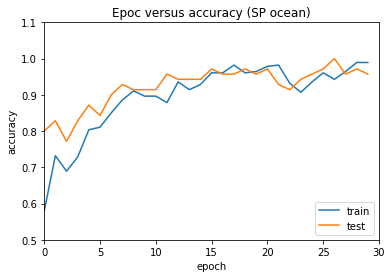

In [8]:
#Generating epoc s train versus test accuracy
noOfTrain = 3 # T = 3 (12 hours)
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)

model = build_model(cnnData.shape)
yy = yy.astype(int)

kf = KFold(n_splits=5, shuffle=True,  random_state=0)
for train_index, test_index in kf.split(cnnData):
    break
   
Xc_train = cnnData[train_index]
yc_train = yy[train_index]

Xc_test = cnnData[test_index]
yc_test = yy[test_index]

history =  model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis([0,30,0.5,1.1]) 
plt.title('Epoc versus accuracy (SP ocean)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Train on 200 samples, validate on 50 samples
Epoch 1/30
200/200 [==============================] - 5s 26ms/sample - loss: 0.6885 - acc: 0.5050 - val_loss: 0.6519 - val_acc: 0.6600
Epoch 2/30
200/200 [==============================] - 0s 2ms/sample - loss: 0.6614 - acc: 0.6500 - val_loss: 0.6112 - val_acc: 0.7200
Epoch 3/30
200/200 [==============================] - 0s 2ms/sample - loss: 0.5800 - acc: 0.7450 - val_loss: 0.4963 - val_acc: 0.7200
Epoch 4/30
200/200 [==============================] - 1s 3ms/sample - loss: 0.5220 - acc: 0.7050 - val_loss: 0.6210 - val_acc: 0.6000
Epoch 5/30
200/200 [==============================] - 0s 2ms/sample - loss: 0.5755 - acc: 0.6950 - val_loss: 0.5546 - val_acc: 0.7000
Epoch 6/30
200/200 [==============================] - 0s 2ms/sample - loss: 0.4889 - acc: 0.7500 - val_loss: 0.4793 - val_acc: 0.7400
Epoch 7/30
200/200 [==============================] - 0s 2ms/sample - loss: 0.4360 - acc: 0.7750 - val_loss: 0.4183 - val_acc: 0.7800
Epoch 8/30
200/2

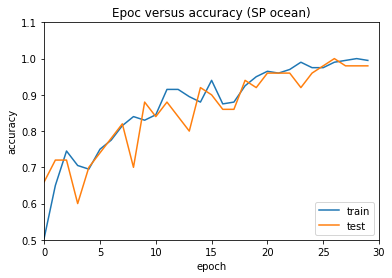

In [9]:
#Generating epoc s train versus test accuracy
noOfTrain = 5 # T = 5 (24 hours)
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)

model = build_model(cnnData.shape)
yy = yy.astype(int)

kf = KFold(n_splits=5, shuffle=True,  random_state=0)
for train_index, test_index in kf.split(cnnData):
    break
   
Xc_train = cnnData[train_index]
yc_train = yy[train_index]

Xc_test = cnnData[test_index]
yc_test = yy[test_index]

history =  model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis([0,30,0.5,1.1]) 
plt.title('Epoc versus accuracy (SP ocean)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()